In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pylab as plt
from time import time 
plt.style.use('default')

# ARIMA model estimating the values of (d,q,p)

In [3]:
df = pd.read_csv('datasets/AEP_hourly.csv')
df['Datetime'] = pd.DatetimeIndex(df.Datetime)
df.set_index('Datetime',inplace=True)
df['Date'] = df.index.date
df = df.groupby('Date')[['AEP_MW']].sum()
df.index = pd.DatetimeIndex(df.index)
df.drop(index=df.index[-1],inplace=True)
df.head()

,AEP_MW
Date,
2004-10-01,328544.0
2004-10-02,311997.0
2004-10-03,293450.0
2004-10-04,343417.0
2004-10-05,346553.0


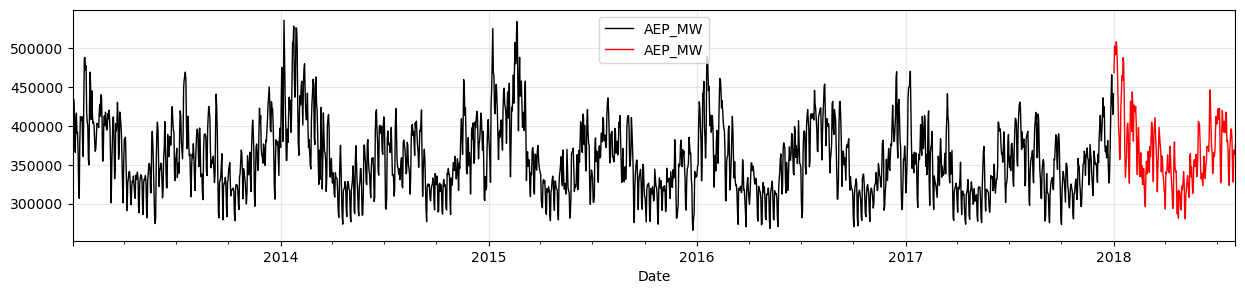

In [4]:
df_train = df[(df.index < pd.Timestamp(day=1,month=1,year=2018)) & (df.index > pd.Timestamp(day=1,month=1,year=2013)) ]
df_test  = df[df.index >= pd.Timestamp(day=1,month=1,year=2018)]

fig,ax = plt.subplots(figsize=(15,3))
df_train[['AEP_MW']].plot(ax=ax,color='k',lw=1,label='Training data')
df_test[['AEP_MW']].plot(ax=ax,color='r',lw=1,label='Validation data')
plt.grid(alpha=0.3)

## Estimation of d

In [5]:
from statsmodels.tsa.stattools import adfuller
test_diff = adfuller(df_train.AEP_MW)
print('ADF Statistic: %f' % test_diff[0])
print('p-value: %f' % test_diff[1])

ADF Statistic: -4.620515
p-value: 0.000118


In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
ts = np.array(df_train.AEP_MW)

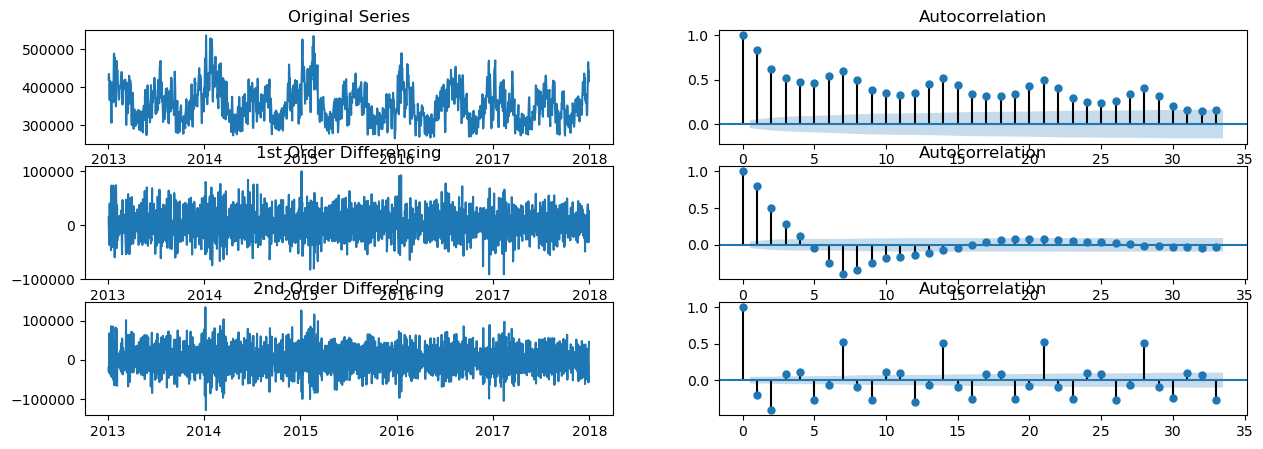

In [7]:
# Original Series
fig, axes = plt.subplots(3, 2,figsize=(15,5))
axes[0, 0].plot(df_train.AEP_MW); axes[0, 0].set_title('Original Series')
plot_acf(df_train.AEP_MW, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df_train.AEP_MW.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_train.AEP_MW.diff(7).dropna() , ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df_train.AEP_MW.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_train.AEP_MW.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

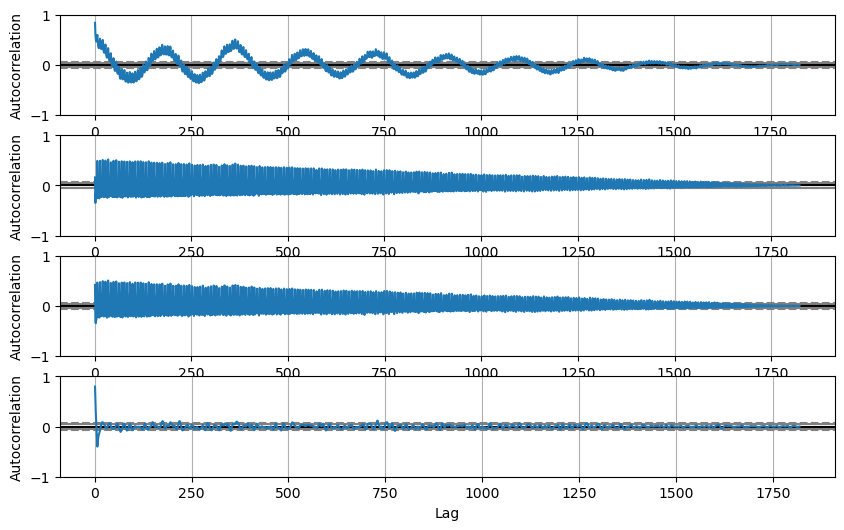

In [8]:
from pandas.plotting import autocorrelation_plot
fig, axes = plt.subplots(4, 1,figsize=(10,6))
axes[0].set_ylim(-1,1);axes[1].set_ylim(-1,1);axes[2].set_ylim(-1,1);axes[3].set_ylim(-1,1);
autocorrelation_plot(df_train,ax=axes[0])
autocorrelation_plot(df_train.diff(1).dropna(),ax=axes[1])
autocorrelation_plot(df_train.diff(2).dropna(),ax=axes[2])
autocorrelation_plot(df_train.diff(7).dropna(),ax=axes[3])

## Estimation of p

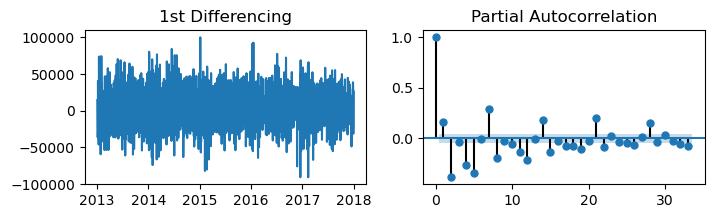

In [9]:
ig, axes = plt.subplots(1, 2,figsize=(8,2))
axes[0].plot(df_train.AEP_MW.diff()); axes[0].set_title('1st Differencing')
plot_pacf(df_train.AEP_MW.diff(1).dropna(), ax=axes[1])
plt.show()

In [10]:
p = 1 

## Estimation of q

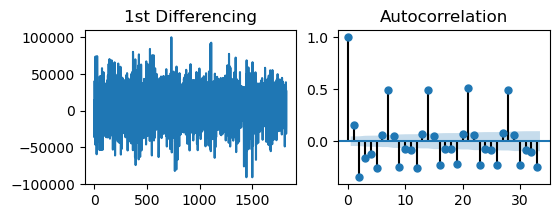

In [11]:
ig, axes = plt.subplots(1, 2,figsize=(6,2))
axes[0].plot(np.diff(ts)); axes[0].set_title('1st Differencing')
plot_acf(np.diff(ts), ax=axes[1])
plt.show()

In [12]:
q = 1

In [13]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

res = sm.tsa.statespace.SARIMAX(df_train['AEP_MW'],order=(3,0,3),seasonal_order=(2,0,1,7)).fit()
res.summary()

/home/alejandro/miniconda3/envs/boost21/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/alejandro/miniconda3/envs/boost21/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/alejandro/miniconda3/envs/boost21/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                              AEP_MW   No. Observations:                 1825
Model:             SARIMAX(3, 0, 3)x(2, 0, [1], 7)   Log Likelihood              -20522.569
Date:                             Wed, 24 Nov 2021   AIC                          41065.138
Time:                                     12:35:17   BIC                          41120.231
Sample:                                 01-02-2013   HQIC                         41085.461
                                      - 12-31-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4330      1.020      1.404      0.160      -0.567       3.433
ar.L2         -0.3426      1.691     -0.203      0.839      -3.657       2.971
ar.L3         -0.0949      0.676     -0.140      0.888      -1.420       1.230
ma.L1         -0.2488      1.015     -0.245      0.806      -2.238       1.741
ma.L2         -0.4592      0.491     -0.936      0.349      -1.421       0.503
ma.L3         -0.1109      0.408     -0.272      0.786      -0.910       0.688
ar.S.L7        0.9958      0.046     21.538      0.000       0.905       1.086
ar.S.L14       0.0040      0.046      0.088      0.930      -0.086       0.095
ma.S.L7       -0.9865      0.012    -83.716      0.000      -1.010      -0.963
sigma2      5.389e+08   6.82e-09    7.9e+16      0.000    5.39e+08    5.39e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               212.26
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             0.24
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.6e+33. Standard errors may be unstable.
"""

In [14]:
x_pred = res.predict(df_train.index[2],df_train.index[-1])

/home/alejandro/miniconda3/envs/boost21/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


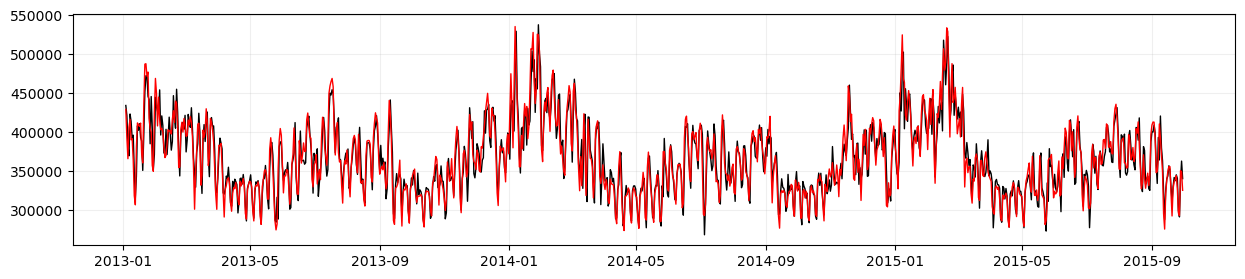

In [15]:
fig,ax = plt.subplots(figsize=(15,3))
plt.plot(x_pred[:1000],color='k',lw=1)
plt.plot(df_train.AEP_MW[2:1002],color='r',lw=1)
plt.grid(alpha=0.2)

In [16]:
x_pred = res.predict(df_test.index[0],df_test.index[-1], typ='levels')

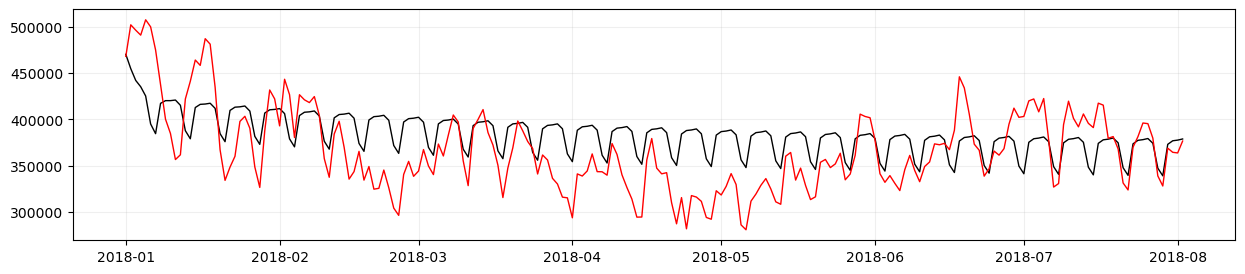

In [17]:
fig,ax = plt.subplots(figsize=(15,3))
plt.plot(x_pred[:],color='k',lw=1)
plt.plot(df_test.AEP_MW[:],color='r',lw=1)
plt.grid(alpha=0.2)

In [18]:
import pmdarima as pm

In [19]:
t1 = time()
model = pm.auto_arima(df_train.AEP_MW, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=7,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=1, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
t2 = time()
fitting_time = t2 - t1

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=41435.705, Time=1.73 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=44360.317, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=41725.002, Time=0.92 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=42983.513, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=51883.980, Time=0.02 sec
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=41636.800, Time=0.33 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=41459.440, Time=1.10 sec
 ARIMA(1,0,1)(2,0,1)[7] intercept   : AIC=41368.931, Time=4.49 sec
 ARIMA(1,0,1)(2,0,0)[7] intercept   : AIC=41368.170, Time=2.96 sec
 ARIMA(0,0,1)(2,0,0)[7] intercept   : AIC=43122.873, Time=2.88 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=41646.923, Time=3.20 sec
 ARIMA(2,0,1)(2,0,0)[7] intercept   : AIC=41317.847, Time=5.27 sec
 ARIMA(2,0,1)(1,0,0)[7] intercept   : AIC=41423.340, Time=2.33 sec
 ARIMA(2,0,1)(2,0,1)[7] intercept   : AIC=41364.213, Time=5.47 sec
 ARIMA(2,0,1)(1,0,1

In [20]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1825
Model:             SARIMAX(3, 0, 3)x(2, 0, [1], 7)   Log Likelihood              -20562.558
Date:                             Wed, 24 Nov 2021   AIC                          41147.115
Time:                                     12:38:41   BIC                          41207.718
Sample:                                          0   HQIC                         41169.471
                                            - 1825                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.036e+04   1.41e+04      3.574      0.000    2.27e+04     7.8e+04
ar.L1         -0.9930      0.072    -13.758      0.000      -1.134      -0.852
ar.L2          0.2552      0.052      4.941      0.000       0.154       0.356
ar.L3          0.6143      0.044     13.998      0.000       0.528       0.700
ma.L1          2.1414      0.079     27.111      0.000       1.987       2.296
ma.L2          1.6679      0.120     13.895      0.000       1.433       1.903
ma.L3          0.3971      0.056      7.096      0.000       0.287       0.507
ar.S.L7        0.7505      0.075      9.971      0.000       0.603       0.898
ar.S.L14       0.1273      0.054      2.340      0.019       0.021       0.234
ma.S.L7       -0.5339      0.077     -6.926      0.000      -0.685      -0.383
sigma2      5.123e+08      1.098   4.67e+08      0.000    5.12e+08    5.12e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):               215.83
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             0.43
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.75e+24. Standard errors may be unstable.
"""

In [21]:
t1 = time()
x_pred = res.predict(df_test.index[0],df_test.index[-1], typ='levels')
t2 = time()
prediction_time = t2-t1

/home/alejandro/miniconda3/envs/boost21/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


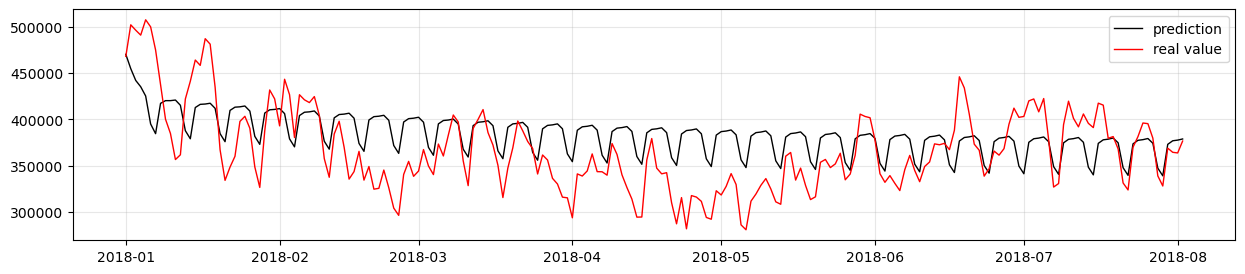

In [22]:
fig,ax = plt.subplots(figsize=(15,3))
plt.plot(df_test.index,x_pred,color='k',lw=1,label='prediction')
plt.plot(df_test.index,df_test.AEP_MW,color='r',lw=1,label='real value')
plt.legend()
plt.grid(alpha=0.3)

In [ ]:
error = mean_squared_error(x_pred,df_test.AEP_MW,squared=False)

In [ ]:
print(f'Fit time        = {fitting_time:.4f}s')
print(f'Prediction time = {prediction_time:.4f}s')
print(f'MSE             = {error:,.0f}')

Fit time        = 203.7818s
Prediction time = 0.0074s
MSE             = 41,811
